In [1]:
import os
import sys
import glob
import tqdm
import math
import librosa
import librosa.display as display
import pickle

import numpy as np
np.random.seed(42)
import pandas as pd

import IPython.display as i_disn
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split


In [2]:
with open(r"X_train_features.pkl","rb") as file:
    X_train_features = pickle.load(file)
    
with open(r"X_test_features.pkl","rb") as file:
    X_test_features = pickle.load(file)
    
with open(r"X_val_features.pkl","rb") as file:
    X_val_features = pickle.load(file)

with open(r"y_train.pkl","rb") as file:
    y_train = pickle.load(file)

with open(r"y_test.pkl","rb") as file:
    y_test = pickle.load(file)

with open(r"y_val.pkl","rb") as file:
    y_val = pickle.load(file)

In [3]:
print("Shape of training data: ", X_train_features.shape)
print("Shape of test data: ", X_test_features.shape)
print("Shape of validation data: ", X_val_features.shape)

Shape of training data:  (22840, 257, 69, 1)
Shape of test data:  (2820, 257, 69, 1)
Shape of validation data:  (2538, 257, 69, 1)


## VAE with MLP

In [4]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2

from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution

disable_eager_execution()
# enable_eager_execution()

In [5]:
def MinMaxScaler(features):
    scaled = []
    for f in features:
        min_val = np.min(f)
        max_val = np.max(f)
        f_normalized = (f - min_val) / (max_val - min_val)
        
        scaled.append(f_normalized)
    return np.array(scaled)

In [6]:
X_train_features  = MinMaxScaler(X_train_features)
X_val_features = MinMaxScaler(X_val_features)
X_test_features = MinMaxScaler(X_test_features)

In [7]:
print("Shape of training data: ", X_train_features.shape)
print("Shape of test data: ", X_test_features.shape)
print("Shape of validation data: ", X_val_features.shape)

Shape of training data:  (22840, 257, 69, 1)
Shape of test data:  (2820, 257, 69, 1)
Shape of validation data:  (2538, 257, 69, 1)


In [8]:
X_train =  X_train_features.reshape(len(X_train_features),np.prod(X_train_features.shape[1:]))
X_test = X_test_features.reshape(len(X_test_features),np.prod(X_test_features.shape[1:]))
X_val = X_val_features.reshape(len(X_val_features),np.prod(X_val_features.shape[1:]))

In [9]:
print("Shape of training data: ", X_train.shape)
print("Shape of test data: ", X_test.shape)
print("Shape of validation data: ", X_val.shape)

Shape of training data:  (22840, 17733)
Shape of test data:  (2820, 17733)
Shape of validation data:  (2538, 17733)


In [10]:

original_dim = X_train.shape[1]
latent_dim = 2  # Size of the latent space



In [11]:
# Encoder network
inputs = Input(shape=(X_train.shape[1],))

x = Dense(4096, activation='relu')(inputs)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
# x = Dense(128, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Reparameterization trick to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch_size = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean #+ K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder network
decoder_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_inputs)
x = Dense(1024, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
outputs = Dense(17733, activation='sigmoid')(x)  # Output layer with sigmoid activation for MNIST

# Define the encoder and decoder models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_inputs, outputs, name='decoder')



In [12]:
# see encoder summary
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 17733)]              0         []                            
                                                                                                  
 dense (Dense)               (None, 4096)                 7263846   ['input_1[0][0]']             
                                                          4                                       
                                                                                                  
 dense_1 (Dense)             (None, 1024)                 4195328   ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 256)                  262400    ['dense_1[0][0]']       

In [13]:
# see decoder summary
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 256)               768       
                                                                 
 dense_4 (Dense)             (None, 1024)              263168    
                                                                 
 dense_5 (Dense)             (None, 4096)              4198400   
                                                                 
 dense_6 (Dense)             (None, 17733)             72652101  
                                                                 
Total params: 77114437 (294.17 MB)
Trainable params: 77114437 (294.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Define the loss function for VAE
def vae_loss(inputs, x_decoded_mean):
    recon_loss = original_dim * binary_crossentropy(inputs, x_decoded_mean)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(recon_loss + kl_loss)

In [15]:
# VAE model
outputs = decoder(encoder(inputs)[2])
dense_vae = Model(inputs, outputs, name='vae')
dense_vae.compile(optimizer='adam', loss=vae_loss)
dense_vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17733)]           0         
                                                                 
 encoder (Functional)        [(None, 2),               77097220  
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 17733)             77114437  
                                                                 
Total params: 154211657 (588.27 MB)
Trainable params: 154211657 (588.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# class TestLossCallback(Callback):
#     def __init__(self, test_data):
#         self.test_data = test_data
#         self.test_losses = []

#     def on_epoch_end(self, epoch, logs=None):
#         test_loss = self.model.evaluate(self.test_data, self.test_data, verbose=0)
#         print(f"\nTest Loss after Epoch {epoch + 1}: {test_loss}")
#         self.test_losses.append(test_loss)

# test_loss_callback = TestLossCallback(X_test)



In [17]:
#  Train the VAE

# dense_vae_history = dense_vae.fit(X_train, X_train, epochs=10, batch_size=128, shuffle=True, validation_data=(X_val, X_val),callbacks=[test_loss_callback])

#  Train the VAE

dense_vae_history = dense_vae.fit(X_train, X_train, epochs=10, batch_size=128, shuffle=True, validation_data=(X_val, X_val))

Train on 22840 samples, validate on 2538 samples
Epoch 1/10


2023-11-15 11:43:55.794913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-15 11:43:55.822457: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_3/kernel/v/Assign' id:774 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_3/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_3/kernel/v, training/Adam/dense_3/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


22840/22840 [==============================] - ETA: 0s - loss: 8249.0136

/Users/rabinnepal/miniforge3/envs/nn_project_env/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-15 11:44:57.160188: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:342 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Test Loss after Epoch 1: 7880.552768312278
22840/22840 [==============================] - 67s 3ms/sample - loss: 8249.0136 - val_loss: 7851.5507
Epoch 2/10
22840/22840 [==============================] - ETA: 0s - loss: 7841.6422
Test Loss after Epoch 2: 7819.298915392287
22840/22840 [==============================] - 67s 3ms/sample - loss: 7841.6422 - val_loss: 7792.4518
Epoch 3/10
22840/22840 [==============================] - ETA: 0s - loss: 7801.9342
Test Loss after Epoch 3: 7793.838030529699
22840/22840 [==============================] - 67s 3ms/sample - loss: 7801.9342 - val_loss: 7768.8381
Epoch 4/10
22840/22840 [==============================] - ETA: 0s - loss: 7784.2850
Test Loss after Epoch 4: 7775.757457197474
22840/22840 [==============================] - 66s 3ms/sample - loss: 7784.2850 - val_loss: 7749.3083
Epoch 5/10
22840/22840 [==============================] - ETA: 0s - loss: 7772.9347
Test Loss after Epoch 5: 7784.28115788453
22840/22840 [============================

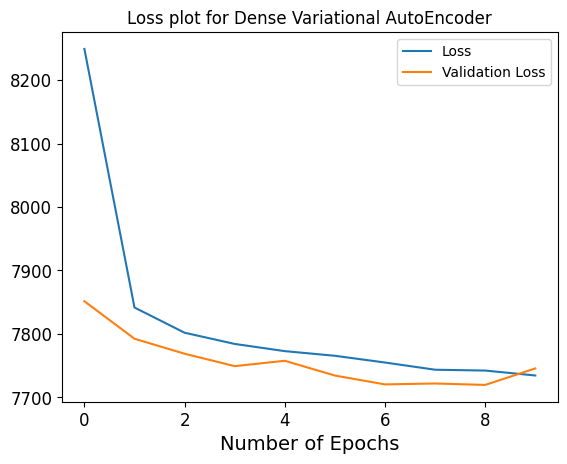

In [18]:
plt.plot(dense_vae_history.history["loss"])
plt.plot(dense_vae_history.history["val_loss"])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss plot for Dense Variational AutoEncoder")
plt.xlabel("Number of Epochs")
plt.ylabel("")
plt.show()

In [19]:
# Evaluate the model on the test data
test_loss = dense_vae.evaluate(X_test, X_test)

In [20]:
test_loss

7767.970927526596

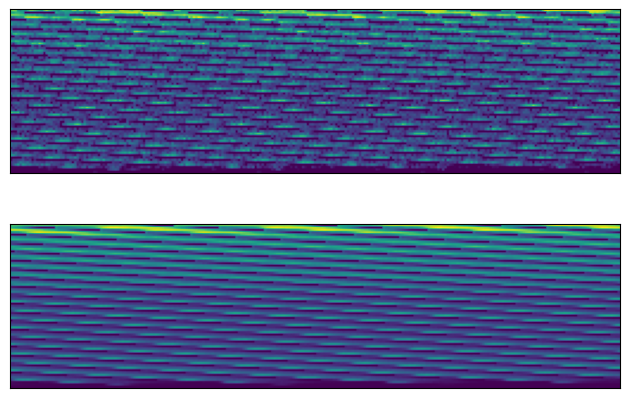

In [27]:
# Generate and visualize reconstructed samples
decoded_imgs = dense_vae.predict(X_test)
n = 1 # Number of samples to visualize
# plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(69, 257))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(69, 257))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()


In [37]:
decoded_imgs = dense_vae.predict(X_train[:20])

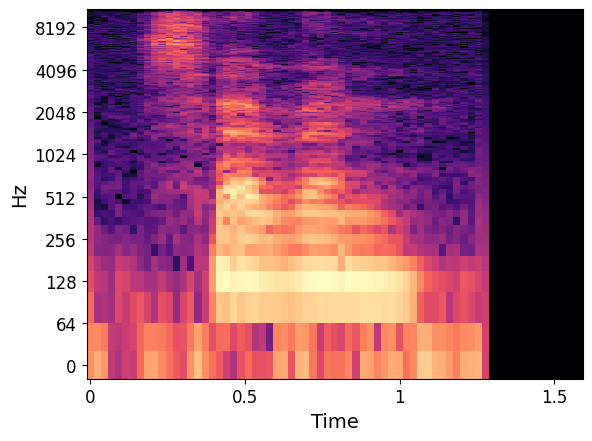

In [31]:
librosa.display.specshow(X_test[0].reshape(257, 69), sr=22050, x_axis='time', y_axis='log')

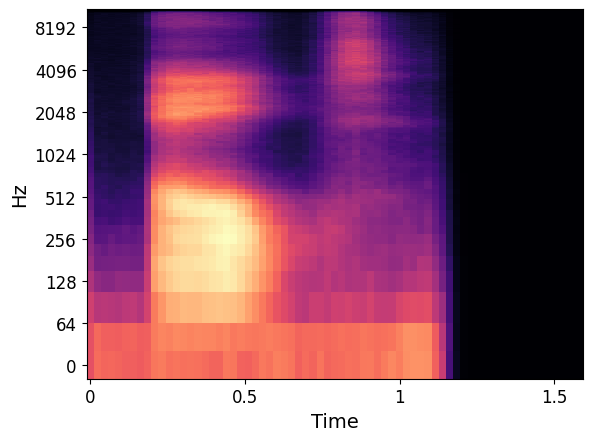

In [38]:
librosa.display.specshow(decoded_imgs[0].reshape(257, 69), sr=22050, x_axis='time', y_axis='log')

In [39]:
abc = librosa.istft(decoded_imgs[0].reshape(257, 69))

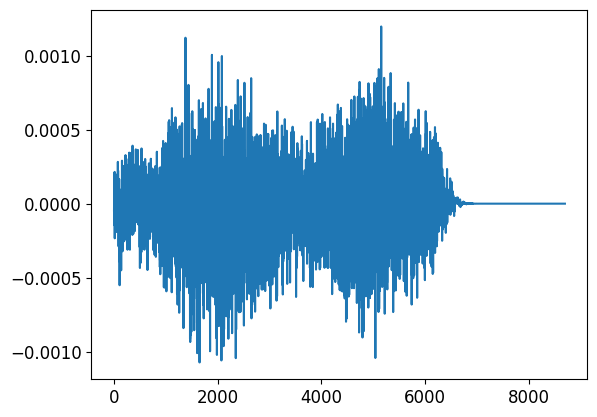

In [40]:
plt.plot(abc)

In [41]:
from IPython.display import Audio

Audio(data=abc,rate=22050)

## VAE with CNN

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

In [ ]:
# Define the Convolutional VAE architecture
input_shape = (1025,81,1)
latent_dim = 2  # Size of the latent space

In [ ]:
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    # return the z mean
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
z = Lambda(sampling)([z_mean, z_log_var])

In [ ]:
encoder = Model(inputs, z)
encoder.summary()

In [ ]:
decoder_input = Input(shape=(latent_dim,))
y = Dense(1025 * 81 * 64, activation='relu')(decoder_input)
y = Reshape((1025, 81, 64))(y)
# y = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(y)
y = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(y)
y = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(y)

In [ ]:
decoder_output = y
decoder = Model(decoder_input,y)

decoder.summary()

In [ ]:
outputs = decoder(encoder(inputs))

In [ ]:
# Define the loss function for VAE
def vae_loss(inputs, outputs):
    xent_loss = K.sum(K.binary_crossentropy(inputs, outputs), axis=(1, 2, 3))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [ ]:
cnn_vae = Model(inputs, outputs)
cnn_vae.compile(optimizer='adam', loss=vae_loss)
cnn_vae.summary()

In [ ]:
# Train the VAE
cnn_vae_history = cnn_vae.fit(X_train_features, X_train_features, epochs=2, batch_size=128, shuffle=True, validation_data=(X_val_features, X_val_features))